# **Data Pipeline**

In [17]:
import yfinance as yf
stocks=["MSFT", "GOOG", "JPM", "NVDA", "TSLA"]
data={}
for stock in stocks:
    data[stock] = yf.download(stock, start="2023-01-01", end="2025-01-01")

    import pandas as pd
    df = yf.download("JPM", start="2023-01-01", end="2024-01-01")

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
ohlc_cols = ["Open", "High", "Low", "Close"]
df[ohlc_cols] = df[ohlc_cols].apply(pd.to_numeric, errors="coerce")

df.dropna(subset=ohlc_cols, inplace=True)

df.index = pd.to_datetime(df.index)




/tmp/ipython-input-3233971758.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[stock] = yf.download(stock, start="2023-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3233971758.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("JPM", start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3233971758.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data[stock] = yf.download(stock, start="2023-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3233971758.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("JPM", start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 comp

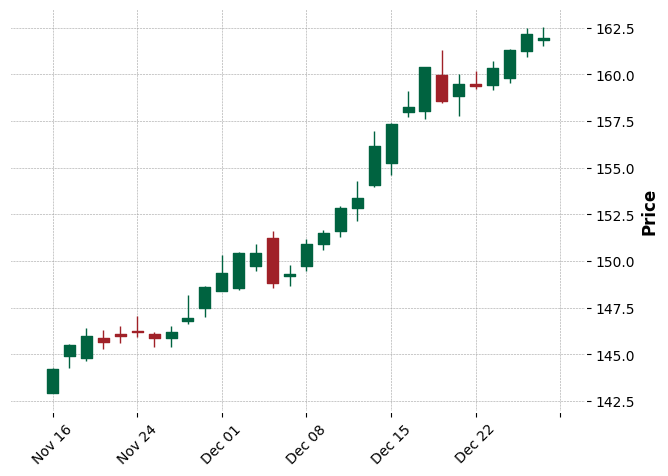

In [18]:
!pip install mplfinance
import mplfinance as mpf
import os

os.makedirs("images", exist_ok=True)
import pandas as pd
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
ohlc_cols = ["Open", "High", "Low", "Close"]
df[ohlc_cols] = df[ohlc_cols].apply(pd.to_numeric, errors="coerce")

df.dropna(subset=ohlc_cols, inplace=True)

df.index = pd.to_datetime(df.index)



mpf.plot(df.iloc[-30:], type="candle", style="charles")


# **Pattern Labeling & Dataset Creation**

In [19]:
class_distribution = {
    "Head & Shoulders": 400,
    "Doji": 400,
    "Hammer": 400,
    "No Pattern": 400
}
class_weight = {0:1, 1:1, 2:1, 3:1}

# **CNN MODEL**

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from PIL import Image

BASE_DIR = "dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")

CLASSES = ["head_shoulders", "doji", "hammer", "no_pattern"]

for split_dir in [TRAIN_DIR, VAL_DIR]:
    for cls in CLASSES:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

def create_dummy_images(path, num_images=10):
    for i in range(num_images):
        img = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        Image.fromarray(img).save(os.path.join(path, f"{i}.png"))

for cls in CLASSES:
    create_dummy_images(os.path.join(TRAIN_DIR, cls), 20)
    create_dummy_images(os.path.join(VAL_DIR, cls), 5)

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(4, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3
)


Found 80 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3460 - loss: 2.6205 - val_accuracy: 0.2500 - val_loss: 1.4203
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2849 - loss: 1.4325 - val_accuracy: 0.2500 - val_loss: 1.3869
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2020 - loss: 1.3953 - val_accuracy: 0.2500 - val_loss: 1.3863


# **Backtesting and Evaluation**

Win Rate: 0.6
Total P&L: 0.045000000000000005
Sharpe Ratio: 9.545941546018394


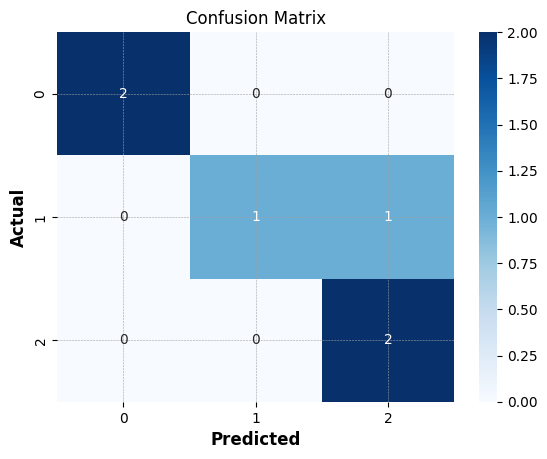

In [21]:
import numpy as np

trade_returns = np.array([0.02, -0.01, 0.03, -0.005, 0.01])

winning_trades = np.sum(trade_returns > 0)
total_trades = len(trade_returns)
win_rate = winning_trades / total_trades
total_pnl = np.sum(trade_returns)
mean_return = np.mean(trade_returns)
std_return = np.std(trade_returns)

sharpe_ratio = (mean_return / std_return) * np.sqrt(252)

print("Win Rate:", win_rate)
print("Total P&L:", total_pnl)
print("Sharpe Ratio:", sharpe_ratio)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = [0, 1, 2, 2, 1, 0]
y_pred = [0, 2, 2, 2, 1, 0]

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
